In [11]:
# import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd

In [18]:
def get_data_from_file():
    data_file = "../data/output2.csv"
    df = pd.read_csv(data_file)
    return list(df['toxicity']), list(df['similarity'])

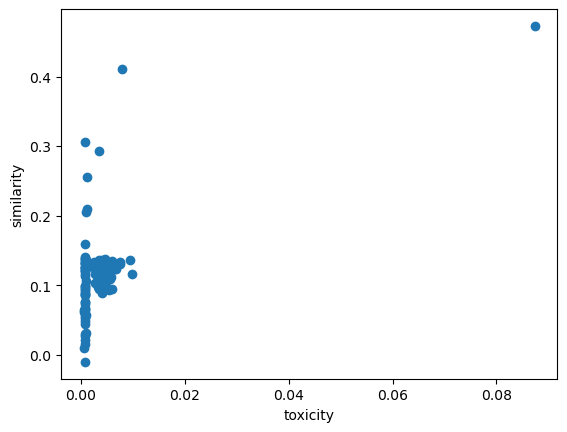

In [19]:
x_axis, y_axis = get_data_from_file()
plt.xlabel("toxicity")
plt.ylabel("similarity")
plt.scatter(x_axis, y_axis)
plt.show()